In [1]:
from dipy.viz import fvtk
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from dipy.reconst import mapmri
from mapmri import mapmri
import datetime

reload(mapmri)

<module 'mapmri.mapmri' from 'mapmri/mapmri.pyc'>

In [15]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import nibabel as nib


def load_subject_medium(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab


def load_subject_small(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab



def mm(A):
    return (int(A.min()), int(A.max()))


Populating the interactive namespace from numpy and matplotlib


## Loading subjects (12, 12, 12) 16 b-vals, 40 gradients

(12, 12, 12, 6) (12, 12, 12, 40) bvals= [1985.0, 3010.0, 995.0, 5.0, 1990.0, 1000.0, 2985.0, 1995.0, 1005.0, 2990.0, 2000.0, 2995.0, 2005.0, 3000.0, 3005.0, 990.0]


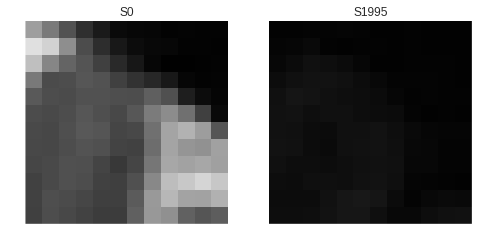

In [3]:
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
bvals5pos = [0,16,32,48,64,80,95,112,128,144,160,176,191,208,224,240,256,272]

# Esto es para quedame con la gtab que es igua a todos
img, gtab = load_subject_medium(0 , subjects)
img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])

i_hr=img.get_data()
S0 = img_s0.get_data()

b=2
img_utils._isc(S0, i_hr, b=b, vmin=S0.min(),  vmax=S0.max(), titles=['S0', 'S'+str(int(gtab.bvals[b]))])
print S0.shape, i_hr.shape, 'bvals=',list(set(gtab.bvals))

In [4]:
"""
Asi tal cual me sugerio Rutger que invoque a los parametros
"""
radial_order = 4
reload(mapmri)
#Fiteo el model
map_model = mapmri.MapmriModel(gtab,
                            radial_order=radial_order,
                            laplacian_regularization=True,
                            laplacian_weighting=0.2,
                            anisotropic_scaling=False,
                            dti_scale_estimation=False)
# Fiteo la data
map_model_fit = map_model.fit(i_hr)
map_model_fit.mapmri_coeff.shape

(12, 12, 12, 22)

In [5]:
# Multiplico por S0 para que se vea como i_hr
Eq_reconst_orig = map_model_fit.fitted_signal(gtab)

for b in xrange(Eq_reconst_orig.shape[3]):
    Eq_reconst_orig[:,:,:,b] = Eq_reconst_orig[:,:,:,b]*S0.mean(axis=3)

print 'Eq_recons desp div S0 max min', mm(Eq_reconst_orig)

Eq_recons desp div S0 max min (-136.3743912352499, 13420.44808718001)


# Compare predit and signal

 (0.00097492992438219517, 1233.6324082580809)
Error relativo max,min u std (3.0176201051045007e-06, 213.36441509546034) 0 0


(-136.3743912352499, 13420.44808718001)

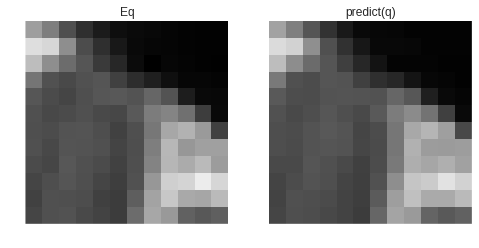

In [7]:
err_mapmrifit = np.abs(Eq_reconst_orig - i_hr)
err_rel_mapmrifit = np.divide(err_mapmrifit, i_hr+1)#para q no de infinito

print mm(err_mapmrifit) 
print 'Error relativo max,min u std', mm(err_rel_mapmrifit), int(err_rel_mapmrifit.mean()), \
                                      int(np.std(err_rel_mapmrifit)) 

img_utils._isc(i_hr, Eq_reconst_orig, vmin=0, vmax=Eq_reconst_orig.max(), titles=['Eq', 'predict(q)'])

mm(Eq_reconst_orig)

## Calculo C con optimizacion

In [30]:
import cvxpy as cvx

def mapl_parameters(gtab):
    radial_order = 4
    map_model = mapmri.MapmriModel(gtab,
                                   radial_order=radial_order,
                                   laplacian_regularization=True,
                                   laplacian_weighting=0.2,
                                   anisotropic_scaling=False,
                                   dti_scale_estimation=False)
    

    mu = map_model.mu
    tau = 1 / (4 * np.pi ** 2) # hasta encontrar el big y small delta en HCP
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = gtab.bvecs * qvals[:, None]
    M = mapmri.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return M, tau


def define_mapl_vars(gtab, vhr, bval, coef, cvxS0=None):
    # MAPL params
    cvxM = cvx.Parameter(bval, coef)
    cvxM.value, tau = mapl_parameters(gtab)
    cvxC = cvx.Variable(vhr, coef)

    if cvxS0 is None:
        cvxS0 = cvx.Parameter(vhr)
        cvxS0.value = np.ones((vhr, 1), dtype='float')*100

    return cvxM, cvxC

def define_opt_problem(i_hr, coef, S0):
    Nx, Ny, Nz, bval = i_hr.shape
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    
    # Image to fit
    Yhr = cvx.Parameter(vhrb, 1)
    Yhr.value = i_hr.reshape(-1, order='F')


    cvxS0 = cvx.Parameter(vhr)
    cvxS0.value = S0.reshape(-1, order='F')
    #cvxS0.value = np.ones(vhr, dtype='float')

    ## MAPL params
    cvxM, cvxC = define_mapl_vars(gtab, vhr, bval, coef, cvxS0)

    ## Mapl regularization
    prob_with_mapl = sum([cvx.sum_squares( cvxM*cvxC[i,:].T - (Yhr[i:vhrb:vhr]/cvxS0[i])) for i in xrange(vhr)])

    alpha = cvx.Parameter(value=.001, sign='positive')
    
    ## objective
    obj = cvx.Minimize(prob_with_mapl + alpha*cvx.norm1(cvxC))

    ## some constraints
    # pos_cons =[ cvxM*cvxC[i,:].T >= 0  for i in xrange(vhr) ]
    # max_cons =[ cvxM*cvxC[i,:].T*cvxS0[i] <= i_hr.max() for i in xrange(vhr) ]

    prob = cvx.Problem(obj)#

    print 'Problema definido Definido ', datetime.datetime.now()
    
    return prob, cvxM, cvxC

In [31]:
coef=22 # 4 --> 22, 6 --> 50
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vhrb = vhr*bval

prob, cvxM, cvxC = define_opt_problem(i_hr, coef, S0.mean(axis=3))

# Solve problem
start_time = time.time()
res = prob.solve(solver='SCS', max_iters=2000, eps=1.00e-10, verbose=True)  # Returns the optimal value.
seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
print "--- status:", prob.status, "optimal value", prob.value
print 

# Change dimension of result representation
if cvxC.value is None :
    print 'FRECONSTRUCTION FAIL :('

C = np.asarray(cvxC.value, dtype='float32').reshape((Nx, Ny, Nz,coef), order='F')
M = np.asarray(cvxM.value, dtype='float32')
    
print '|C| =', np.linalg.norm(C)
print 'minimzation op_val =', prob.value

Problema definido Definido  2016-08-25 11:06:46.286394
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1676160, CG tol ~ 1/iter^(2.00)
eps = 1.00e-10, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 77760, constraints m = 148608
Cones:	linear vars: 76032
	soc vars: 72576, soc blks: 1728
Setup time: 9.36e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  1.40e-01 
   100| 5.03e-04  1.64e-03  1.13e-03  2.44e+02  2.43e+02  2.72e-13  3.65e+00 
   200| 3.07e-04  1.09e-03  9.57e-04  2.4

## Compare C 

In [32]:
dif_c = np.abs(C - map_model_fit.mapmri_coeff)
ecm_c = ((C - map_model_fit.mapmri_coeff)**2).mean()

print '|dif_c| min/max:', int(np.linalg.norm(dif_c)), mm(dif_c) 
print '|C| |Corig|:',  int(np.linalg.norm(C)), int(np.linalg.norm(map_model_fit.mapmri_coeff))
print 'ecm :', ecm_c

|dif_c| min/max: 7 (0, 1)
|C| |Corig|: 52 52
ecm : 0.0014341110773


(array([  1.40000000e+01,   8.40000000e+01,   1.24000000e+02,
          2.49000000e+02,   3.51620000e+04,   1.28500000e+03,
          8.69000000e+02,   9.90000000e+01,   9.60000000e+01,
          3.40000000e+01]),
 array([-2.396173  , -1.86147959, -1.32678618, -0.79209278, -0.25739937,
         0.27729404,  0.81198745,  1.34668086,  1.88137426,  2.41606767,
         2.95076108]),
 <a list of 10 Patch objects>)

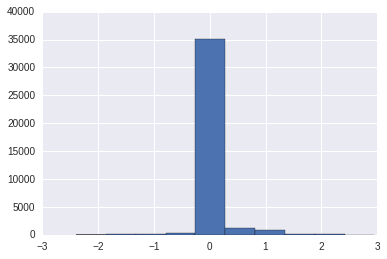

In [33]:
hist(C.flatten())

(array([  2.00000000e+00,   2.00000000e+01,   1.55000000e+02,
          2.77000000e+02,   3.57770000e+04,   1.27200000e+03,
          3.62000000e+02,   1.32000000e+02,   1.70000000e+01,
          2.00000000e+00]),
 array([-3.04472989, -2.34913615, -1.65354242, -0.95794869, -0.26235496,
         0.43323877,  1.1288325 ,  1.82442623,  2.52001996,  3.21561369,
         3.91120743]),
 <a list of 10 Patch objects>)

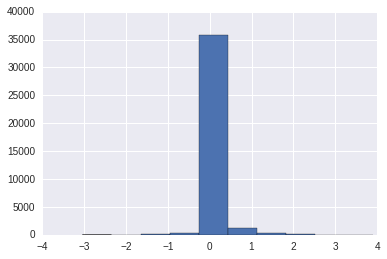

In [34]:
hist( map_model_fit.mapmri_coeff.flatten())

(0, 13620)


((-136, 13420), (0, 0))

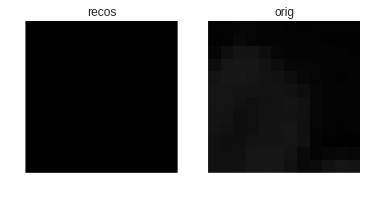

In [37]:
"""
QUEREMOS VER SI EL C QUE OBTUVIMOS ES PARECIDO 
AL CALCULADO POR MAPMRI
"""

def mypredict(gtab, M, C, i_hr_shape):
    Nx, Ny, Nz, Nb = i_hr_shape
    vhr=Nx*Ny*Nz
    tau = 1 / (4 * np.pi ** 2)
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    #M = mapmri_isotropic_phi_matrix(self.radial_order, self.mu[0], q)
    E = np.dot(M, C.reshape(vhr, coef).T).reshape(i_hr_shape)
    return E
 

Eq_reconst = mypredict(gtab, M, map_model_fit.mapmri_coeff, i_hr.shape)
for b in xrange(Eq_reconst.shape[3]):
    Eq_reconst[:,:,:,b] = Eq_reconst[:,:,:,b]*S0.mean(axis=3)

err = np.abs(Eq_reconst - Eq_reconst_orig)
err_rel = np.divide(err, Eq_reconst_orig+1)


#img_utils._isc(i_hr, err_rel, b=2,vmin=0, vmax=i_hr.max(), titles=['Eq', 'predict(q)'])
img_utils._isc(Eq_reconst, Eq_reconst_orig, b=2,vmin=0, vmax=Eq_reconst_orig.max(), titles=['recos', 'orig'])
print mm(i_hr)

mm(Eq_reconst_orig), mm(Eq_reconst)

(0, 117577015) (12, 12, 12, 40)


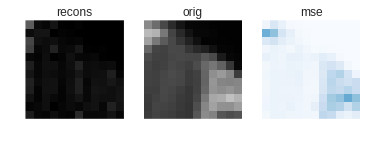

In [21]:
mses = ((Eq_reconst - Eq_reconst_orig)**2)/2
print mm(mses), mses.shape
res = img_utils._isc3(Eq_reconst,Eq_reconst_orig, mses, vmax=Eq_reconst.max(), titles=['recons', 'orig', 'mse'])
res[0].clim(mm(mses))

(array([ 43406.,  21391.,   1359.,   1428.,    405.,    312.,    330.,
           225.,    201.,     63.]),
 array([  -136.37439124,   1219.30785661,   2574.99010445,   3930.67235229,
          5286.35460013,   6642.03684797,   7997.71909581,   9353.40134366,
         10709.0835915 ,  12064.76583934,  13420.44808718]),
 <a list of 10 Patch objects>)

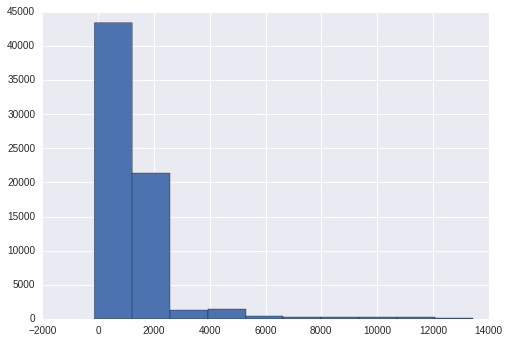

In [31]:
hist(Eq_reconst_orig.flatten())

(array([  4.48620000e+04,   1.41090000e+04,   6.37000000e+03,
          1.92900000e+03,   8.01000000e+02,   5.45000000e+02,
          3.95000000e+02,   9.50000000e+01,   9.00000000e+00,
          5.00000000e+00]),
 array([  -252.79449463,   1347.48573608,   2947.7659668 ,   4548.04619751,
          6148.32642822,   7748.60665894,   9348.88688965,  10949.16712036,
         12549.44735107,  14149.72758179,  15750.0078125 ]),
 <a list of 10 Patch objects>)

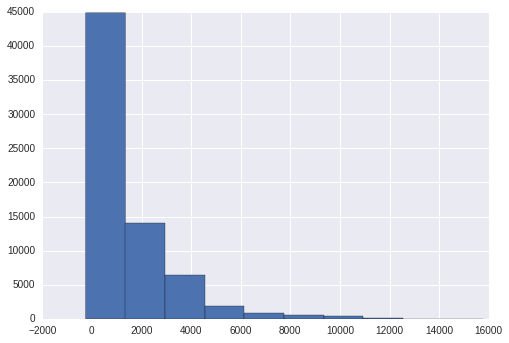

In [32]:
hist(Eq_reconst.flatten())

# DTI 3d (intento)

In [ ]:
#DTI con cvxp

cvBvals = cvx.Parameter(bval)
cvBvals.value = gtab.bvals

cvBvecs = cvx.Parameter(bval,3)
cvBvecs.value = gtab.bvecs

Ds = [ cvx.Semidef(3) for i in xrange(vhr)]

cvB = cvx.diag(cvBvals)*cvBvecs # (bval, 3)

BDBs = [cvx.diag(cvB*Ds[i]*cvB.T) for i in xrange(vhr)]

print 'BDBs', BDBs[0].size

"""
# Opcion A (suma voxel by voxel by bval)
dti_sum = []
for i in xrange(vhr):
    for b in xrange(bval):
        dti_sum.append(cvx.exp(-1*BDBs[i][b]) - Yhr[i+b*vhr]) 
"""

#v = cvx.Variable()#,0]
#cvx.exp(v)

print BDBs[0][1].size

# Opcion B suma de cuadrados por cada voxel
dti_list = []
for i in xrange(vhr):
    Yi = Yhr[i:vhrb:vhr]
    dti_list = [ cvx.square( cvx.exp(BDBs[i][b]) - Yi[b] )  for b in xrange(bval)]

dti = sum(dti_sum)
        
cvx.Minimize(dti)


BDBs (40, 1)
(1, 1)
